<a href="https://colab.research.google.com/github/Ibinmbiju/Recap/blob/main/3_0_tl_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3


## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [5]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch

    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # set the model to train mode
    model.train()

    # enumerate over the dataloader to get mini batches of images and ground truth labels
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # set the optimizers gradients to zero
        optimizer.zero_grad()

        # run the network
        output = model(data)

        # compute negative log likelihood loss
        loss = F.nll_loss(output, target)

        # do backpropagation
        loss.backward()

        # optimize
        optimizer.step()

        # print current loss for every nth ("log_interval"th) iteration
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [4]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics

    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)

    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0

    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()

            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()

            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()

            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10

                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))

                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0

                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)

                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())

                plotted += 1
                img_idx += 1

    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FCNet1(nn.Module):
    """
    Fully Connected Neural Network

    Five fully connected layers with sigmoid non-linearity

    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()

        # initialize network layers
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)


    def forward(self, x):
        # reshape batch of images to batch of 1D vectors
        x = x.view(-1, 784)

        # run network layers
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        x = self.fc5(x) #No sigmoid on the last layer

        # compute log softmax over the output
        output = F.log_softmax(x, dim=1)

        return output

In [9]:
class FCNet2(nn.Module):
    """
    Fully Connected Neural Network with ReLU activation
    """
    def __init__(self):
        super(FCNet2, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)  # No activation on the last layer
        output = F.log_softmax(x, dim=1)
        return output

In [10]:
class FCNet3(nn.Module):
    """
    Fully Connected Neural Network with ReLU activation and BatchNorm
    """
    def __init__(self):
        super(FCNet3, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.bn1 = nn.BatchNorm1d(200) # BatchNorm1d for 1D output
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.bn2 = nn.BatchNorm1d(60) # BatchNorm1d for 1D output
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.bn2(self.fc3(x)))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)  # No activation on the last layer
        output = F.log_softmax(x, dim=1)
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet1(nn.Module):
    """
    Convolutional Neural Network

    Two convolutional layers and two fully connected layers

    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()

        # Initialize network layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1) #padding to maintain size
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2) #stride to reduce size

        #Calculate the output size after convolutional layers for fully connected layer input
        #  After conv1: 32 x 28 x 28
        #  After conv2: 64 x 13 x 13 (because of stride 2)
        self.fc1 = nn.Linear(in_features=64 * 13 * 13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):
        # Run convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # Reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 13 * 13) #flatten the tensor

        # Run fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Compute log softmax over the output
        output = F.log_softmax(x, dim=1)

        return output

In [13]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Batch norm after conv1
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.fc1 = nn.Linear(in_features=64 * 13 * 13, out_features=128)
        self.bn2 = nn.BatchNorm1d(128)  # Batch norm after fc1
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) # Apply batch norm after conv1 activation
        x = F.relu(self.conv2(x))
        x = x.view(-1, 64 * 13 * 13)
        x = F.relu(self.bn2(self.fc1(x))) # Apply batch norm after fc1 activation
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [14]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Max pooling layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Max pooling layer
        self.fc1 = nn.Linear(in_features=64 * 12 * 12, out_features=128) # Adjust input size
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x) # Apply max pooling
        x = F.relu(self.conv2(x))
        x = self.pool2(x) # Apply max pooling
        x = x.view(-1, 64 * 12 * 12) # Adjust to match pooling output size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305086
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.351184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.222334
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.411182
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.230913
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.150776
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.032380
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.079293
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.115265
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.038885

Test set: Average loss: 0.1461, Accuracy: 9570/10000 (95.70%)



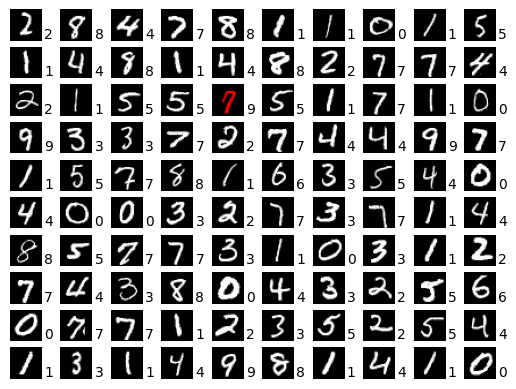

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.249378
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.179492
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.093661
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.192945
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.138276
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.028953
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.101592
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.009208
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.062309
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.086106

Test set: Average loss: 0.0917, Accuracy: 9745/10000 (97.45%)



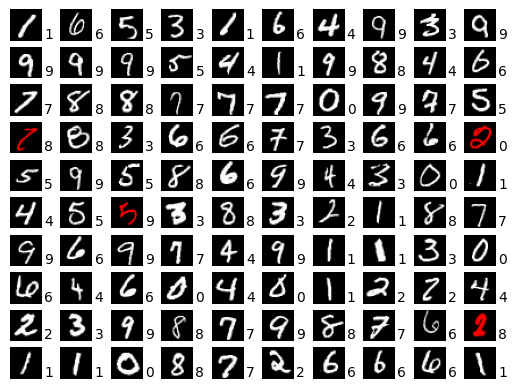

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.007490
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.014016
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.019838
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.050241
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.004193
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.049796
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.147367
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.014894
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.007322
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.056736

Test set: Average loss: 0.0845, Accuracy: 9767/10000 (97.67%)



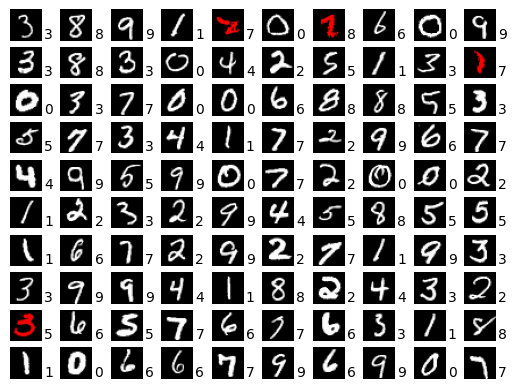

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.024186
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.018500
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.004819
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.026423
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.004902
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.004372
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.019830
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.083178
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.013822
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.003232

Test set: Average loss: 0.0767, Accuracy: 9798/10000 (97.98%)



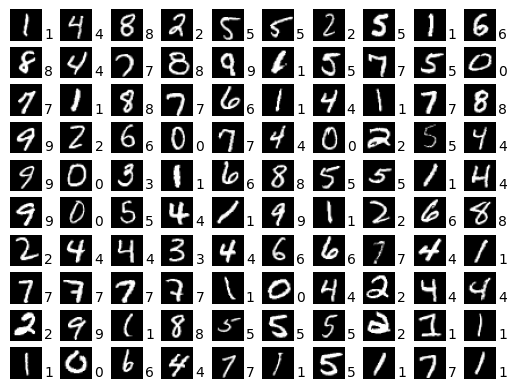

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.004475
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.064561
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.011662
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.006383
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.001155
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.003306
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.065948
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.000619
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.069340
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.010749

Test set: Average loss: 0.0763, Accuracy: 9812/10000 (98.12%)



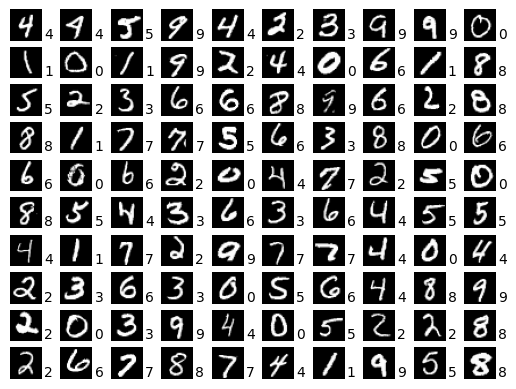

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.007725
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.001383
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.059406
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.004665
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.002772
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.001857
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.001286
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.001233
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000694
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.001717

Test set: Average loss: 0.0751, Accuracy: 9828/10000 (98.28%)



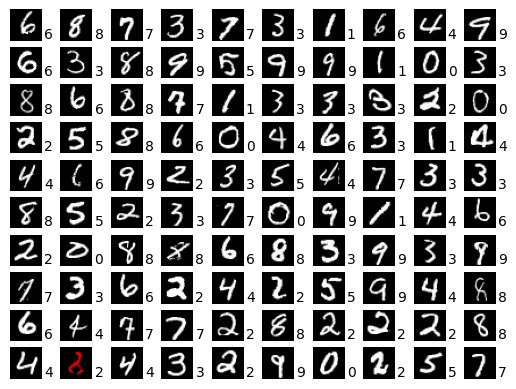

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.030632
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.005771
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.001361
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.000923
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.003345
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.002910
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.001464
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.000363
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.004019
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.074534

Test set: Average loss: 0.0812, Accuracy: 9827/10000 (98.27%)



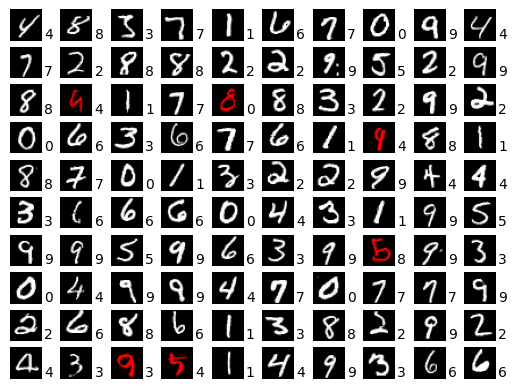

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.008128
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.000390
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.001510
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.000784
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.006903
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000088
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.192792
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.000619
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.022645
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.005903

Test set: Average loss: 0.0811, Accuracy: 9829/10000 (98.29%)



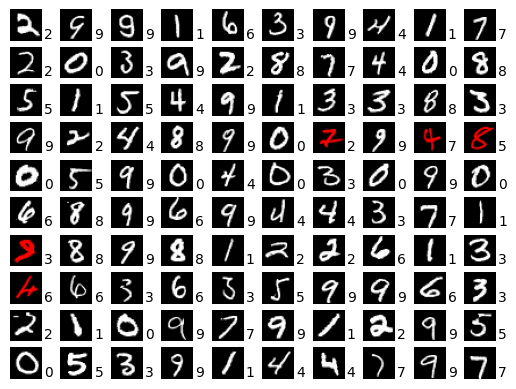

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.004356
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.001608
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.001012
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.003911
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.001350
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.001154
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000819
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.003284
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000168
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000467

Test set: Average loss: 0.0829, Accuracy: 9837/10000 (98.37%)



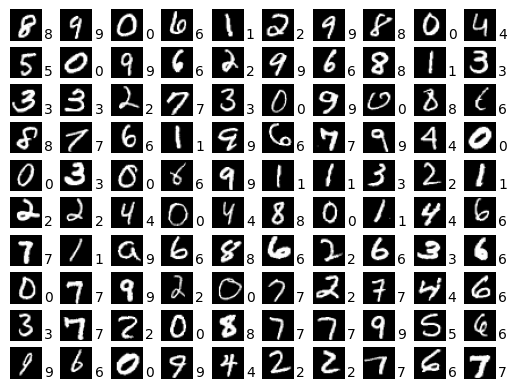

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.001475
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.005836
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.001031
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.000842
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.000405
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.003029
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.000722
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.000646
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.000255
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.002352

Test set: Average loss: 0.0855, Accuracy: 9827/10000 (98.27%)



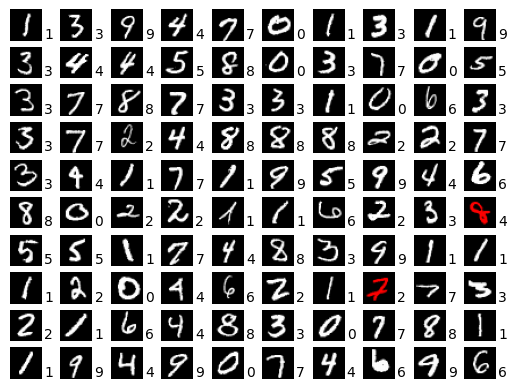

In [16]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)

    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()


    torch.save(model.state_dict(), "./checkpoint.pt")